<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">実行準備（ライブラリのimport）</span>
</div>

* **処理（下のコードセルで実現すること）**：本コードで使用するライブラリをimportする
* **入力（実行するために必要な情報）**：無し（以下で定義済み）
* **出力（実行後に生成される成果物）**：無し（以下のライブラリを使用できるようになる）

In [ ]:
#ライブラリのimport
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import time
import shutil
import shap
import locale
import seaborn as sns
import matplotlib as mpl
from dateutil.relativedelta import relativedelta
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
from datetime import datetime
from PIL import Image

<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">実行準備（パスの定義）</span>
</div>

## ＜概要（下のコードセルの簡単な説明）＞
* **処理（下のコードセルで実現すること）**：本コードで使用する各種データセットのパスを定義。
* **入力（実行するために必要な情報）**：無し（以下で定義済み）
* **出力（実行後に生成される成果物）**：無し（パス変数の生成）

In [88]:
#生データのパス
folder_path_zaikoMB = '生データ/在庫推移MB'
folder_path_LTMB = '生データ/所在管理MB'
folder_path_kumitate = '生データ/組立実績MB'
folder_path_tehaisu = '生データ/手配必要数'
folder_path_tehaiunyo = '生データ/手配運用情報'
folder_path_pitch = '生データ/不等ピッチ係数'
folder_path_kotei = '生データ/使用工程'
#中間成果物のパス
folder_path_interproduct = '中間成果物'
file_path_zaikodata = '中間成果物/在庫推移MBデータ_統合済.csv'
file_path_LTdata = '中間成果物/所在管理MBデータ_統合済.csv'
file_path_kumitate = '中間成果物/組立実績MBデータ_統合済.csv'
file_path_pitch = '中間成果物/不等ピッチデータ_統合済.csv'
file_path_kotei = '中間成果物/使用工程データ_統合済.csv'
file_path_date= '中間成果物/日付ファイル_開始日と終了日記載.txt'
file_path_zaikodata_extract = '中間成果物/在庫推移MBデータ_統合済&特定日時抽出済.csv'
file_path_LTdata_extract = '中間成果物/所在管理MBデータ_統合済&特定日時抽出済.csv'
file_path_kumitate_extract = '中間成果物/組立実績MBデータ_統合済&特定日時抽出済.csv'
file_path_tehaisu_with_tehaiunyo = '中間成果物/手配数データ_手配運用情報統合済'#.csvいらない
#新規追加
file_path_kanban_count_data_by_hour = '中間成果物/単位時間当たりのかんばん数データ.csv'
file_path_kanban_count_rackzaiko_data = '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データ.csv'
file_path_kanban_count_rackzaiko_data_flag_and_sum = '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データのフラグ＆量.csv'
file_path_teikibin_count_data_by_hour = '中間成果物/単位時間当たりの荷役時間データ.csv'
file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin = '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データのフラグ＆量&荷役時間データ.csv'
file_path_kumitatedaisu_adjusted = '中間成果物/単位時間当たりの組立生産台数データ.csv'
file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu = '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データのフラグ＆量&荷役時間&組立生産台数データ.csv'
file_path_robot_and_maguchi = '中間成果物/ロボット＆間口データ.csv'
file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu_and_robot_and_maguchi = \
  '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データのフラグ＆量&荷役時間&組立生産台数&ロボットと間口データ.csv'
#最終成果物のパス
folder_path_finalproduct = '最終成果物'

<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">データの抽出（特定日時入力）</span>
</div>

## ＜概要（下のコードセルの簡単な説明）＞
* **処理（下のコードセルで実現すること）**：ユーザーにキーボード入力を要求し、特定の日付範囲を入力
* **入力（実行するために必要な情報）**：任意の日付範囲（ユーザーのキーボード入力）
* **出力（実行後に生成される成果物）**：入力した日付範囲を記録したテキストファイル（中間成果物/日付ファイル_開始日と終了日記載.txt）

In [111]:
#日付範囲の設定例
#start_date_input='2023-10-01'
#end_date_input ='2024-03-30'

# ユーザーからの入力を受け付けて特定の日付範囲のDataFrameを取り出す
start_date_input = input("You：開始日を入力してください（YYYY-MM-DD）: ")
end_date_input = input("You：終了日を入力してください（YYYY-MM-DD）: ")

#日付範囲の記録用ファイル作成
with open(file_path_date, 'w') as file:
    file.write("開始日:"+start_date_input)
    file.write("\n")
    file.write("終了日:"+end_date_input)

You：開始日を入力してください（YYYY-MM-DD）:  2023-10-01
You：終了日を入力してください（YYYY-MM-DD）:  2024-03-30


<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">過去のかんばん枚数の計算</span>
</div>

## ＜概要（下のコードセルの簡単な説明）＞
* **処理（下のコードセルで実現すること）**：過去のかんばん枚数の計算
* **入力（実行するために必要な情報）**：〇〇
* **出力（実行後に生成される成果物）**：〇〇

In [182]:
def process_kanbandata_to_generate_kanban_count_data_by_hour(
    file_path, datetime_column, order_quantity_column, start_date=None, end_date=None):
    
    # CSVファイルの読み込み
    data = pd.read_csv(file_path, encoding='shift_jis')

    # 日時カラムを datetime 形式に変換
    data[datetime_column] = pd.to_datetime(data[datetime_column], errors='coerce')

    # 品番ごとに1時間ごとの〇〇かんばん数を集計
    data['YYYYMMDDH'] = data[datetime_column].dt.floor('H')
    hourly_orders = data.groupby(['品番', 'YYYYMMDDH']).size().reset_index(name=order_quantity_column)

    # 1時間前から23時間前の〇〇かんばん数を計算
    for i in range(1, 23):
        hourly_orders[f'{i}時間前の{order_quantity_column}'] = hourly_orders.groupby('品番')[order_quantity_column].shift(i)

    # 対象時間範囲のデータフレームを作成
    #　　start_data、end_dateが定義されていれば、使用
    min_time = pd.to_datetime(start_date) if start_date else data[datetime_column].min()
    max_time = pd.to_datetime(end_date)   if end_date   else data[datetime_column].max()
    all_times = pd.date_range(start=min_time.floor('H'), end=max_time.ceil('H'), freq='H')

    # 品番ごとに対象時間範囲のデータフレームを作成し、元の集計データとマージ
    product_time_combinations = pd.MultiIndex.from_product([data['品番'].unique(), all_times], names=['品番', 'YYYYMMDDH'])
    full_data = pd.DataFrame(index=product_time_combinations).reset_index()
    full_data = full_data.merge(hourly_orders, on=['品番', 'YYYYMMDDH'], how='left')
    for i in range(1, 50):
        full_data[f'{i}時間前の{order_quantity_column}'] = full_data.groupby('品番')[order_quantity_column].shift(i)
    full_data.fillna(0, inplace=True)  # 一括でNaNを0に変換
    return full_data

#発注かんばん枚数の計算
datetime_column = '印刷日時'
order_quantity_column = '発行かんばん数'
hatyu_data = process_kanbandata_to_generate_kanban_count_data_by_hour(
    file_path_LTdata_extract, datetime_column, order_quantity_column, start_date, end_date)

#納入かんばん枚数の計算
datetime_column = '検収日時'
order_quantity_column = '納入かんばん数'
nonyu_data = process_kanbandata_to_generate_kanban_count_data_by_hour(
    file_path_LTdata_extract, datetime_column, order_quantity_column, start_date, end_date)

#統合する
merged_data_for_kanban = pd.merge(hatyu_data, nonyu_data, on=['品番','YYYYMMDDH'], how='left')
merged_data_for_kanban['品番'] = merged_data_for_kanban['品番'].str.replace(r'\s+', '', regex=True)

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_data_by_hour, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_kanban.to_csv(f)

#例表示
merged_data_for_kanban[merged_data_for_kanban['品番'] == '019128GA010'].head(5)

,品番,YYYYMMDDH,発行かんばん数,1時間前の発行かんばん数,2時間前の発行かんばん数,3時間前の発行かんばん数,4時間前の発行かんばん数,5時間前の発行かんばん数,6時間前の発行かんばん数,7時間前の発行かんばん数,...,40時間前の納入かんばん数,41時間前の納入かんばん数,42時間前の納入かんばん数,43時間前の納入かんばん数,44時間前の納入かんばん数,45時間前の納入かんばん数,46時間前の納入かんばん数,47時間前の納入かんばん数,48時間前の納入かんばん数,49時間前の納入かんばん数
95590,019128GA010,2023-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95591,019128GA010,2023-10-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95592,019128GA010,2023-10-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95593,019128GA010,2023-10-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95594,019128GA010,2023-10-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">在庫増減、過去の入庫数の計算</span>
</div>

## ＜概要（下のコードセルの簡単な説明）＞
* **処理（下のコードセルで実現すること）**：〇〇
* **入力（実行するために必要な情報）**：〇〇
* **出力（実行後に生成される成果物）**：〇〇

In [183]:
#かんばんCSVファイルの読み込み
kanban_count_data = pd.read_csv(file_path_kanban_count_data_by_hour, encoding='shift_jis')

#自動ラックCSVファイルの読み込み
rackzaiko_data = pd.read_csv(file_path_zaikodata_extract, encoding='shift_jis')
rackzaiko_data['在庫増減数'] = rackzaiko_data["入庫数（箱）"] - rackzaiko_data["出庫数（箱）"]
#列名の変更
rackzaiko_data = rackzaiko_data.rename(columns={'計測日時': 'YYYYMMDDH'})

# '品番'が文字列でない場合は文字列に変換
kanban_count_data['品番'] = kanban_count_data['品番'].astype(str)
rackzaiko_data['品番'] = rackzaiko_data['品番'].astype(str)
rackzaiko_data['品番'] = rackzaiko_data['品番'].str.replace(r'\s+', '', regex=True)

# 全品番の「入庫数（箱）」の日付ごとの合計を計算
#total_incoming_per_date = rackzaiko_data.groupby('YYYYMMDDH')['入庫数（箱）'].sum().reset_index().rename(columns={'入庫数（箱）': '日時別入庫数合計'})

# 元のデータフレームに追加
#rackzaiko_data = rackzaiko_data.merge(total_incoming_per_date, on='YYYYMMDDH')

# 各行の品番を除いた他の品番の同日の「入庫数（箱）」の合計を計算
#rackzaiko_data['他品番の入庫数（箱）合計'] = rackzaiko_data['日時別入庫数合計'] - rackzaiko_data['入庫数（箱）']

# 'YYYYMMDDH' を datetime 型に変換（エラーが出ないようにする）
kanban_count_data['YYYYMMDDH'] = pd.to_datetime(kanban_count_data['YYYYMMDDH'], errors='coerce')
kanban_count_data['YYYYMMDDH'] = kanban_count_data['YYYYMMDDH'].dt.strftime('%Y-%m-%d-%H:%M:%S')
rackzaiko_data['YYYYMMDDH'] = pd.to_datetime(rackzaiko_data['YYYYMMDDH'], errors='coerce')
rackzaiko_data['YYYYMMDDH'] = rackzaiko_data['YYYYMMDDH'].dt.strftime('%Y-%m-%d-%H:%M:%S')

merged_data_for_kanban_and_rackzaiko = pd.merge(kanban_count_data, rackzaiko_data, on=['品番','YYYYMMDDH'], how='left')
# 不要な「Unnamed」列を削除                
merged_data_for_kanban_and_rackzaiko = merged_data_for_kanban_and_rackzaiko.loc[:, ~merged_data_for_kanban_and_rackzaiko.columns.str.contains('^Unnamed')]
#NaNを含む行を削除
merged_data_for_kanban_and_rackzaiko = merged_data_for_kanban_and_rackzaiko.dropna(subset=['在庫数（箱）'])

# 全品番の「入庫数（箱）」の日付ごとの合計を計算
total_incoming_per_date = merged_data_for_kanban_and_rackzaiko.groupby('YYYYMMDDH')['入庫数（箱）'].sum().reset_index().rename(columns={'入庫数（箱）': '日時別入庫数合計'})

# 元のデータフレームに追加
merged_data_for_kanban_and_rackzaiko = merged_data_for_kanban_and_rackzaiko.merge(total_incoming_per_date, on='YYYYMMDDH')

# 各行の品番を除いた他の品番の同日の「入庫数（箱）」の合計を計算
merged_data_for_kanban_and_rackzaiko['他品番の入庫数（箱）合計'] = merged_data_for_kanban_and_rackzaiko['日時別入庫数合計'] - merged_data_for_kanban_and_rackzaiko['入庫数（箱）']

# 不要な列を削除
merged_data_for_kanban_and_rackzaiko = merged_data_for_kanban_and_rackzaiko.drop(columns='日時別入庫数合計')

#過去の入庫数を計算
merged_data_for_kanban_and_rackzaiko["入庫数（箱）1時間前"]=merged_data_for_kanban_and_rackzaiko["入庫数（箱）"].shift(1)
merged_data_for_kanban_and_rackzaiko["入庫数（箱）2時間前"]=merged_data_for_kanban_and_rackzaiko["入庫数（箱）"].shift(2)
merged_data_for_kanban_and_rackzaiko["入庫数（箱）3時間前"]=merged_data_for_kanban_and_rackzaiko["入庫数（箱）"].shift(3)
merged_data_for_kanban_and_rackzaiko["入庫数（箱）4時間前"]=merged_data_for_kanban_and_rackzaiko["入庫数（箱）"].shift(4)
merged_data_for_kanban_and_rackzaiko["入庫数（箱）合計"] = \
    merged_data_for_kanban_and_rackzaiko['入庫数（箱）'] + \
    merged_data_for_kanban_and_rackzaiko["入庫数（箱）1時間前"] + \
    merged_data_for_kanban_and_rackzaiko["入庫数（箱）2時間前"] + \
    merged_data_for_kanban_and_rackzaiko["入庫数（箱）3時間前"] + \
    merged_data_for_kanban_and_rackzaiko["入庫数（箱）4時間前"]

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_kanban_and_rackzaiko.to_csv(f)

#例を表示
merged_data_for_kanban_and_rackzaiko[merged_data_for_kanban_and_rackzaiko['品番'] == '019128GA010'].head(5)
#merged_data_for_kanban_and_rackzaiko.head(50)

,品番,YYYYMMDDH,発行かんばん数,1時間前の発行かんばん数,2時間前の発行かんばん数,3時間前の発行かんばん数,4時間前の発行かんばん数,5時間前の発行かんばん数,6時間前の発行かんばん数,7時間前の発行かんばん数,...,在庫数（箱）,入庫数（箱）,出庫数（箱）,在庫増減数,他品番の入庫数（箱）合計,入庫数（箱）1時間前,入庫数（箱）2時間前,入庫数（箱）3時間前,入庫数（箱）4時間前,入庫数（箱）合計
20,019128GA010,2023-10-01-00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214,019128GA010,2023-10-01-01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
408,019128GA010,2023-10-01-02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,019128GA010,2023-10-01-03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,019128GA010,2023-10-01-04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">発注納入フラグ、発注量、納入量の計算</span>
</div>

## ＜概要（下のコードセルの簡単な説明）＞
* **処理（下のコードセルで実現すること）**：〇〇
* **入力（実行するために必要な情報）**：〇〇
* **出力（実行後に生成される成果物）**：〇〇

In [314]:
def process_kanban_count_data_to_generate_flag_and_sum(df):
    
    order_prefix = '発行'

    # 'X時間前の発注かんばん数'の列を特定
    previous_order_columns = [col for col in df.columns if '時間前の' + order_prefix + 'かんばん数' in col]
    
    # '発注かんばん数'のフラグと量の列を用意
    df[order_prefix + 'かんばん数（フラグ）'] = 0

    # '発注かんばん数' => 1 の場合、フラグを1に設定
    mask_order_greater_than_one = df[order_prefix + 'かんばん数'] >= 1
    df.loc[mask_order_greater_than_one, order_prefix + 'かんばん数（フラグ）'] = 1

    # 各'X時間前の発注かんばん数'列に対してフラグ列を用意し、同様に更新
    for col in previous_order_columns:
        flag_col = f'{col}（フラグ）'
        df[flag_col] = 0
        mask_previous_order_greater_than_one = df[col] >= 1
        df.loc[mask_previous_order_greater_than_one, flag_col] = 1
    
    # 列名から時間数を抽出し、その範囲をチェック
    selected_columns = [
        col for col in previous_order_columns 
        if 20 <= int(re.search(r'(\d+)時間前', col).group(1)) <= 30
    ]
    
    # 新しい列「発行量」を初期化
    df[order_prefix + '量'] = df[selected_columns].astype(int).sum(axis=1)
    
    # 新しい列「発注量」を初期化
    #df[order_prefix + '量'] = 0
    
    # 12時間前から8時間前の間の列だけを「発注量」に加える
    #for col in selected_columns:
        #df[order_prefix + '量'] += int(df[col])

    #全ての時間幅で合計を計算する場合    
    # 「発注かんばん数」を「発注量」に加える
    #df[order_prefix + '量'] += df[order_prefix + 'かんばん数']
    # 各「X時間前の発注かんばん数」も「発注量」に加える
    #for col in previous_order_columns:
        #df[order_prefix + '量'] += df[col]
        
    #------------------------------------------------------------------------------------------------
    
    order_prefix = '納入'
    
    # 'X時間前の発注かんばん数'の列を特定
    previous_order_columns = [col for col in df.columns if '時間前の' + order_prefix + 'かんばん数' in col]
    
    # '発注かんばん数'のフラグと量の列を用意
    df[order_prefix + 'かんばん数（フラグ）'] = 0

    # '発注かんばん数' => 1 の場合、フラグを1に設定
    mask_order_greater_than_one = df[order_prefix + 'かんばん数'] >= 1
    df.loc[mask_order_greater_than_one, order_prefix + 'かんばん数（フラグ）'] = 1

    # 各'X時間前の発注かんばん数'列に対してフラグ列を用意し、同様に更新
    for col in previous_order_columns:
        flag_col = f'{col}（フラグ）'
        df[flag_col] = 0
        mask_previous_order_greater_than_one = df[col] >= 1
        df.loc[mask_previous_order_greater_than_one, flag_col] = 1
    
    # 新しい列「発注量」を初期化
    df[order_prefix + '量'] = 0
    
    # 列名から時間数を抽出し、その範囲をチェック
    selected_columns = [
        col for col in previous_order_columns 
        if 5 <= int(re.search(r'(\d+)時間前', col).group(1)) <= 9
    ]
    
    # 新しい列「発行量」を初期化
    df[order_prefix + '量'] = df[selected_columns].astype(int).sum(axis=1)
    
    # 新しい列「発注量」を初期化
    #df[order_prefix + '量'] = 0
    
    # 12時間前から8時間前の間の列だけを「発注量」に加える
    #for col in selected_columns:
        #df[order_prefix + '量'] += int(df[col])

    #全ての時間幅で合計を計算する場合
    # 「発注かんばん数」を「発注量」に加える
    #df[order_prefix + '量'] += df[order_prefix + 'かんばん数']
    # 各「X時間前の発注かんばん数」も「発注量」に加える
    #for col in previous_order_columns:
        #df[order_prefix + '量'] += df[col]

    return df

#かんばん＆自動ラックCSVファイルの読み込み
kanban_count_rackzaiko_data = pd.read_csv(file_path_kanban_count_rackzaiko_data, encoding='shift_jis')
# 不要な「Unnamed」列を削除                
kanban_count_rackzaiko_data = kanban_count_rackzaiko_data.loc[:, ~kanban_count_rackzaiko_data.columns.str.contains('^Unnamed')]

# 関数の適用
merged_data_for_flag_and_sum = process_kanban_count_data_to_generate_flag_and_sum(kanban_count_rackzaiko_data)

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data_flag_and_sum, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_flag_and_sum.to_csv(f)

merged_data_for_flag_and_sum.head()

,品番,YYYYMMDDH,発行かんばん数,1時間前の発行かんばん数,2時間前の発行かんばん数,3時間前の発行かんばん数,4時間前の発行かんばん数,5時間前の発行かんばん数,6時間前の発行かんばん数,7時間前の発行かんばん数,...,41時間前の納入かんばん数（フラグ）,42時間前の納入かんばん数（フラグ）,43時間前の納入かんばん数（フラグ）,44時間前の納入かんばん数（フラグ）,45時間前の納入かんばん数（フラグ）,46時間前の納入かんばん数（フラグ）,47時間前の納入かんばん数（フラグ）,48時間前の納入かんばん数（フラグ）,49時間前の納入かんばん数（フラグ）,納入量
0,9031150A015,2023-10-01-00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,9031150A014,2023-10-01-00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,9030119A010,2023-10-01-00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,9030119A011,2023-10-01-00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,34989ECB020,2023-10-01-00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


[<matplotlib.lines.Line2D at 0x144305610>]

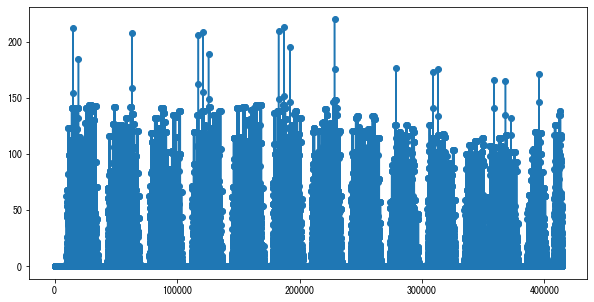

In [317]:
#merged_data_for_flag_and_sum["発行量"].head()
plt.figure(figsize=(10, 5))
plt.plot(merged_data_for_flag_and_sum['発行量'], marker='o')

<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">荷役時間の計算</span>
</div>

## ＜概要（下のコードセルの簡単な説明）＞
* **処理（下のコードセルで実現すること）**：〇〇
* **入力（実行するために必要な情報）**：〇〇
* **出力（実行後に生成される成果物）**：〇〇

In [289]:
def add_previous_hours_data(df, X):
    """
    データフレームに1時間前からX時間前までの「便合計」のデータ列を追加する関数。

    Args:
    df (DataFrame): 入力データフレーム。
    X (int): 追加する時間の範囲（1時間前からX時間前まで）。

    Returns:
    DataFrame: 更新されたデータフレーム。
    """
    for i in range(1, X + 1):
        df[f'{i}時間前荷役時間'] = df['荷役時間'].shift(i)
    return df

#ファイル読み込み
file_path_teikibin = '定期便.csv'
teikibin_data = pd.read_csv(file_path_teikibin, encoding='shift_jis')

# 日時の列を datetime 型に変換
teikibin_data['JISEKI_DT'] = pd.to_datetime(teikibin_data['JISEKI_DT'])
teikibin_data['JISEKI_DT2'] = pd.to_datetime(teikibin_data['JISEKI_DT2'])
#1時間単位に変換
teikibin_data['定期便到着時刻（1H）'] = pd.to_datetime(teikibin_data['JISEKI_DT']).dt.floor('H')
teikibin_data['定期便出発時刻（1H）'] = pd.to_datetime(teikibin_data['JISEKI_DT2']).dt.floor('H')
# 日時の差を計算
teikibin_data["荷役時間"] = teikibin_data['JISEKI_DT2'] - teikibin_data['JISEKI_DT']

# 各WORK_IDと定期便到着時刻（1H）の組み合わせに対して荷役時間の合計を計算
grouped = teikibin_data.groupby(['WORK_ID', '定期便到着時刻（1H）'])['荷役時間'].sum().reset_index()

# 1時間毎のデータフレームに各WORK_IDごとの「定期便到着時刻（1H）」列を追加する
date_range = pd.date_range(start = start_date, end = end_date, freq='H')

# YYYYMMDDHに全ての時間帯をマッピング
all_hours_df = pd.DataFrame(date_range, columns=['YYYYMMDDH']).set_index('YYYYMMDDH')

# 結果を保存するための空のDataFrameを準備
result_df = all_hours_df.copy()

# 元のデータセットからユニークなWORK_IDを抽出する
unique_work_ids = teikibin_data['WORK_ID'].unique()

for work_id in unique_work_ids:
    # 特定のWORK_IDに対する荷役時間を含む時間帯のデータフレームを抽出
    work_times = grouped[grouped['WORK_ID'] == work_id]
    work_times = work_times.set_index('定期便到着時刻（1H）')
    # 荷役時間を1時間ごとのデータフレームにマージ
    result_df[f'荷役時間_便_{work_id}'] = work_times['荷役時間']

result_df_reset = result_df.reset_index()

# 荷役時間を分単位に変換し、float型で保存するために、Timedeltaを分に変換する処理を行います。
for col in result_df_reset.columns:
    if "便" in col:
        # Timedeltaを分に変換
        result_df_reset[col] = result_df_reset[col].dt.total_seconds() / 60

pattern_columns = result_df_reset.filter(regex='荷役時間_便_[0\d\W]+').columns
print(pattern_columns)

result_df_reset['荷役時間']=result_df_reset[pattern_columns].sum(axis=1)
result_df_reset.fillna(0, inplace=True)  # 一括でNaNを0に変換

# 関数を使用してデータフレームを更新
X = 8  # 1時間前から5時間前までのデータ列を追加
updated_df = add_previous_hours_data(result_df_reset, X)

# 更新されたデータフレームの最初の数行を表示して内容を確認
updated_df.head()

# 統合したデータを新しいCSVファイルに保存
with open(file_path_teikibin_count_data_by_hour, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    result_df_reset.to_csv(f)

# 結果の一部を表示して確認
result_df_reset.head(100)
# 日付範囲に基づいてデータをフィルタリング
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-06')
f = result_df_reset[(result_df_reset['YYYYMMDDH'] >= start_date_temp) & (result_df_reset['YYYYMMDDH'] <= end_date_temp)]
f.head(20)

Index(['荷役時間_便_01', '荷役時間_便_02', '荷役時間_便_03', '荷役時間_便_04', '荷役時間_便_05',
       '荷役時間_便_06', '荷役時間_便_0K'],
      dtype='object')


,YYYYMMDDH,荷役時間_便_01,荷役時間_便_02,荷役時間_便_03,荷役時間_便_04,荷役時間_便_05,荷役時間_便_06,荷役時間_便_0K,荷役時間,1時間前荷役時間,2時間前荷役時間,3時間前荷役時間,4時間前荷役時間,5時間前荷役時間,6時間前荷役時間,7時間前荷役時間,8時間前荷役時間
96,2023-10-05 00:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450,0.000000
97,2023-10-05 01:00:00,0.0000,0.000000,0.00000,0.0,41.56105,0.000000,0.0,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450
98,2023-10-05 02:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000
99,2023-10-05 03:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000
100,2023-10-05 04:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000
101,2023-10-05 05:00:00,0.0000,0.000000,0.00000,0.0,0.00000,32.464383,0.0,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167
102,2023-10-05 06:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000
103,2023-10-05 07:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000
104,2023-10-05 08:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000
105,2023-10-05 09:00:00,31.4504,0.000000,0.00000,0.0,0.00000,0.000000,0.0,31.450400,0.000000,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050


In [290]:
#ファイル読み込み
merged_data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum, encoding='shift_jis')
#ファイル読み込み
teikibin_data = pd.read_csv(file_path_teikibin_count_data_by_hour, encoding='shift_jis')
print(len(merged_data),len(teikibin_data))

teikibin_data['YYYYMMDDH'] = pd.to_datetime(teikibin_data['YYYYMMDDH'])
merged_data['YYYYMMDDH'] = pd.to_datetime(merged_data['YYYYMMDDH'])

merged_data_for_flag_and_sum_teikibin = pd.merge(merged_data, teikibin_data, on=['YYYYMMDDH'], how='left')
# 不要な「Unnamed」列を削除                
merged_data_for_flag_and_sum_teikibin = merged_data_for_flag_and_sum_teikibin.loc[:, ~merged_data_for_flag_and_sum_teikibin.columns.str.contains('^Unnamed')]
print(len(merged_data_for_flag_and_sum_teikibin))

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_flag_and_sum_teikibin.to_csv(f)

# 日付範囲に基づいてデータをフィルタリング
merged_data_for_flag_and_sum_teikibin.head()
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-06')
f = merged_data_for_flag_and_sum_teikibin[
    (merged_data_for_flag_and_sum_teikibin['YYYYMMDDH'] >= start_date_temp) & (merged_data_for_flag_and_sum_teikibin['YYYYMMDDH'] <= end_date_temp)]
f.head(20)

414187 4345
414187


,品番,YYYYMMDDH,発行かんばん数,1時間前の発行かんばん数,2時間前の発行かんばん数,3時間前の発行かんばん数,4時間前の発行かんばん数,5時間前の発行かんばん数,6時間前の発行かんばん数,7時間前の発行かんばん数,...,荷役時間_便_0K,荷役時間,1時間前荷役時間,2時間前荷役時間,3時間前荷役時間,4時間前荷役時間,5時間前荷役時間,6時間前荷役時間,7時間前荷役時間,8時間前荷役時間
18495,9031150A015,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18496,9031150A014,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18497,9030119A010,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18498,9030119A011,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18499,34989ECB020,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18500,33490ECE010,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18501,G9201ECB030,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18502,G9201ECE010,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18503,9034118060,2023-10-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0
18504,33490ECB010,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0


<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">生産台数の計算</span>
</div>

## ＜概要（下のコードセルの簡単な説明）＞
* **処理（下のコードセルで実現すること）**：〇〇
* **入力（実行するために必要な情報）**：〇〇
* **出力（実行後に生成される成果物）**：〇〇

In [291]:
#KUMI_ID邪魔だな

# 時間を調整する関数を定義
def adjust_hours(row):
    hour_map = {
        1: {1: 8, 2: 9, 3: 10, 4: 11, 5: 12, 6: 13, 7: 14, 8: 15, 9: 16, 10: 17, 11: 18, 12: 19, 13: 20},
        2: {1: 21, 2: 22, 3: 23, 4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7, 12: 8, 13: 9}
    }
    tyoku_kbn = row['TYOKU_KBN(1)']
    jikankbn = row['JIKANWARI_KBN']
    if tyoku_kbn in hour_map and jikankbn in hour_map[tyoku_kbn]:
        adjusted_date = row['LINE_DATE'].replace(hour=hour_map[tyoku_kbn][jikankbn])
    else:
        # デフォルトとして現在の時間を保持（この行は通常必要ありませんが、明確性のために含めています）
        adjusted_date = row['LINE_DATE']
    return adjusted_date

file_path_kumitatedaisu = '組立生産台数.csv'
kumitate_data = pd.read_csv(file_path_kumitatedaisu, encoding='shift_jis')

# 'LINE_DATE'列をdatetime型に変換
kumitate_data['LINE_DATE'] = pd.to_datetime(kumitate_data['LINE_DATE'])

# 時間調整関数を適用して新しい列を作成
kumitate_data['YYYYMMDDH'] = kumitate_data.apply(adjust_hours, axis=1)

# 'PLAN_PRODUCT_CNT' にNaNがある行を削除
kumitate_data = kumitate_data.dropna(subset=['PRODUCT_CNT'])

# 'PLAN_PRODUCT_CNT' の値が0である行を除外
# 日付のダブり防止
kumitate_data = kumitate_data[kumitate_data['PLAN_PRODUCT_CNT'] != 0]

#後で変数化する
# 日付列でデータフレームを降順に並び替える
kumitate_data['PRODUCT_CNT（1時間前）']=kumitate_data['PRODUCT_CNT'].shift(1)
kumitate_data['PRODUCT_CNT（2時間前）']=kumitate_data['PRODUCT_CNT'].shift(2)

kumitate_data['PRODUCT_CNT（合計）']=kumitate_data['PRODUCT_CNT']+kumitate_data['PRODUCT_CNT（1時間前）']+kumitate_data['PRODUCT_CNT（2時間前）']

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kumitatedaisu_adjusted, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    kumitate_data.to_csv(f)

kumitate_data.head(15)
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-07')
f = kumitate_data[(kumitate_data['YYYYMMDDH'] >= start_date_temp) & (kumitate_data['YYYYMMDDH'] <= end_date_temp)]
f.head(24)

,LINE_DATE,JIKANWARI_KBN,KUMI_CD,TYOKU_KBN(1),PRODUCT_CNT,PLAN_PRODUCT_CNT,YYYYMMDDH,PRODUCT_CNT（1時間前）,PRODUCT_CNT（2時間前）,PRODUCT_CNT（合計）
208,2023-10-05,1,NH11,1,118.0,120.0,2023-10-05 08:00:00,98.0,106.0,322.0
212,2023-10-05,2,NH11,1,130.0,130.0,2023-10-05 09:00:00,118.0,98.0,346.0
215,2023-10-05,2,NH12,2,118.0,120.0,2023-10-05 22:00:00,130.0,118.0,366.0
216,2023-10-05,3,NH11,1,104.0,108.0,2023-10-05 10:00:00,118.0,130.0,352.0
219,2023-10-05,3,NH12,2,128.0,130.0,2023-10-05 23:00:00,104.0,118.0,350.0
220,2023-10-05,4,NH11,1,130.0,130.0,2023-10-05 11:00:00,128.0,104.0,362.0
223,2023-10-05,4,NH12,2,108.0,108.0,2023-10-05 00:00:00,130.0,128.0,366.0
227,2023-10-05,5,NH12,2,128.0,128.0,2023-10-05 01:00:00,108.0,130.0,366.0
228,2023-10-05,6,NH11,1,93.0,98.0,2023-10-05 13:00:00,128.0,108.0,329.0
232,2023-10-05,7,NH11,1,126.0,130.0,2023-10-05 14:00:00,93.0,128.0,347.0


In [292]:
#ファイル読み込み
merged_data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin, encoding='shift_jis')
#ファイル読み込み
kumitatedaisu_data = pd.read_csv(file_path_kumitatedaisu_adjusted, encoding='shift_jis')
print(len(merged_data),len(kumitatedaisu_data))

kumitatedaisu_data['YYYYMMDDH'] = pd.to_datetime(kumitatedaisu_data['YYYYMMDDH'])
merged_data['YYYYMMDDH'] = pd.to_datetime(merged_data['YYYYMMDDH'])

#生産台数の統合
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu = pd.merge(
    merged_data, kumitatedaisu_data[['YYYYMMDDH', 'PRODUCT_CNT','PRODUCT_CNT（合計）', 'PLAN_PRODUCT_CNT']], on=['YYYYMMDDH'], how='left')
# 不要な「Unnamed」列を削除                
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu = merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu.loc[:, 
                                                                                                                      ~merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu.columns.str.contains('^Unnamed')]
# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu.to_csv(f)

merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu.head(5)
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-06')
temp = merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu
f = temp[(temp['YYYYMMDDH'] >= start_date_temp) & (temp['YYYYMMDDH'] <= end_date_temp)]
f.head(20)

414187 3185


,品番,YYYYMMDDH,発行かんばん数,1時間前の発行かんばん数,2時間前の発行かんばん数,3時間前の発行かんばん数,4時間前の発行かんばん数,5時間前の発行かんばん数,6時間前の発行かんばん数,7時間前の発行かんばん数,...,2時間前荷役時間,3時間前荷役時間,4時間前荷役時間,5時間前荷役時間,6時間前荷役時間,7時間前荷役時間,8時間前荷役時間,PRODUCT_CNT,PRODUCT_CNT（合計）,PLAN_PRODUCT_CNT
18495,9031150A015,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18496,9031150A014,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18497,9030119A010,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18498,9030119A011,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18499,34989ECB020,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18500,33490ECE010,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18501,G9201ECB030,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18502,G9201ECE010,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18503,9034118060,2023-10-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0
18504,33490ECB010,2023-10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.277167,0.0,0.0,0.0,47.71745,0.0,108.0,366.0,108.0


<div style="background-color:navy; padding: 15px; border: 2px solid black;">
    <span style="font-weight:bold; color:white; font-size:30px;">間口の計算</span>
</div>

## ＜概要（下のコードセルの簡単な説明）＞
* **処理（下のコードセルで実現すること）**：〇〇
* **入力（実行するために必要な情報）**：〇〇
* **出力（実行後に生成される成果物）**：〇〇

In [293]:
#自動ラックCSVファイルの読み込み
rackzaiko_data = pd.read_csv(file_path_zaikodata_extract, encoding='shift_jis')
#列名の変更
rackzaiko_data = rackzaiko_data.rename(columns={'計測日時': 'YYYYMMDDH'})
#品番の修正
rackzaiko_data['品番'] = rackzaiko_data['品番'].astype(str).str.replace("-", "").str.replace(" ", "").str.rstrip()
# NaN を 0 で置き換え
rackzaiko_data.fillna(0, inplace=True)

# 計測日時ごとに入庫数と出庫数の合計を計算
summary_rackzaiko_data = rackzaiko_data.groupby('YYYYMMDDH').agg({
    '入庫数（箱）': 'sum',
    '出庫数（箱）': 'sum'
}).reset_index()

# 品番グループデータの読み込み（仮のパスを使用）
group_data = pd.read_csv("ラック間口.csv", encoding='shift_jis')
group_data['品番'] = group_data['品番'].astype(str).str.replace("-", "").str.replace(" ", "").str.rstrip()

# 在庫データの読み込み（すでに読み込んでいるデータを使用）
stock_data = rackzaiko_data

# 品番グループデータと在庫データの結合
merged_data = pd.merge(stock_data, group_data, on='品番', how='left')

# 計測日時と間口ごとに在庫数を集計
pivot_table = merged_data.pivot_table(
    values='在庫数（箱）',
    index='YYYYMMDDH',
    columns='間口',
    aggfunc='sum'
)

# 特定の品番グループの列だけを選択
result = pivot_table[['A1', 'A2', 'B1','B2', 'B3','B4']].copy()

# 列名をリネームして明確化
result.rename(columns={
    'A1': '在庫数（箱）合計_A1',
    'A2': '在庫数（箱）合計_A2',
    'B1': '在庫数（箱）合計_B1',
    'B2': '在庫数（箱）合計_B2',
    'B3': '在庫数（箱）合計_B3',
    'B4': '在庫数（箱）合計_B4'
}, inplace=True)

# インデックスをリセットして、元のインデックスを列に含める
result_reset = result.reset_index()

#ロボット間口の統合
merged_data_for_robot_and_maguchi = pd.merge(
    summary_rackzaiko_data[['YYYYMMDDH', '入庫数（箱）']], result_reset[['YYYYMMDDH', '在庫数（箱）合計_A1','在庫数（箱）合計_A2', 
                                                                   '在庫数（箱）合計_B1', '在庫数（箱）合計_B2','在庫数（箱）合計_B3', '在庫数（箱）合計_B4']], on=['YYYYMMDDH'], how='left')

# 統合したデータを新しいCSVファイルに保存
with open(file_path_robot_and_maguchi, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_robot_and_maguchi.to_csv(f)

# 結果の表示
#result_reset.head(50)
merged_data_for_robot_and_maguchi.head(1500)

,YYYYMMDDH,入庫数（箱）,在庫数（箱）合計_A1,在庫数（箱）合計_A2,在庫数（箱）合計_B1,在庫数（箱）合計_B2,在庫数（箱）合計_B3,在庫数（箱）合計_B4
0,2023-10-01 00:00:00,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
1,2023-10-01 01:00:00,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
2,2023-10-01 02:00:00,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
3,2023-10-01 03:00:00,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
4,2023-10-01 04:00:00,0.0,1471.0,920.0,654.0,510.0,299.0,18.0
...,...,...,...,...,...,...,...,...
1495,2023-12-02 07:00:00,169.0,1565.0,865.0,591.0,571.0,285.0,13.0
1496,2023-12-02 08:00:00,1.0,1564.0,864.0,591.0,563.0,285.0,13.0
1497,2023-12-02 09:00:00,0.0,1564.0,864.0,591.0,563.0,285.0,13.0
1498,2023-12-02 10:00:00,0.0,1558.0,864.0,591.0,563.0,285.0,13.0


In [294]:
#ファイル読み込み
merged_data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu, encoding='shift_jis')
#ファイル読み込み
robot_and_maguchidata = pd.read_csv(file_path_robot_and_maguchi, encoding='shift_jis')

#統合
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi = pd.merge(
    merged_data, robot_and_maguchidata, on=['YYYYMMDDH'], how='left')
# 不要な「Unnamed」列を削除                
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi = merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi.loc[:, 
                                                                                                                      ~merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi.columns.str.contains('^Unnamed')]
# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu_and_robot_and_maguchi, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi.to_csv(f)
    
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi.head()

,品番,YYYYMMDDH,発行かんばん数,1時間前の発行かんばん数,2時間前の発行かんばん数,3時間前の発行かんばん数,4時間前の発行かんばん数,5時間前の発行かんばん数,6時間前の発行かんばん数,7時間前の発行かんばん数,...,PRODUCT_CNT,PRODUCT_CNT（合計）,PLAN_PRODUCT_CNT,入庫数（箱）_y,在庫数（箱）合計_A1,在庫数（箱）合計_A2,在庫数（箱）合計_B1,在庫数（箱）合計_B2,在庫数（箱）合計_B3,在庫数（箱）合計_B4
0,9031150A015,2023-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,106.0,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
1,9031150A014,2023-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,106.0,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
2,9030119A010,2023-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,106.0,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
3,9030119A011,2023-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,106.0,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
4,34989ECB020,2023-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,106.0,0.0,1472.0,920.0,654.0,510.0,299.0,18.0


In [395]:
#ファイル読み込み
data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu_and_robot_and_maguchi, encoding='shift_jis')
data.fillna(0, inplace=True)  # 一括でNaNを0に変換
# 文字列をタイムスタンプ型に変換
data['YYYYMMDDH'] = pd.to_datetime(data['YYYYMMDDH'])

#特定品番
date_temp =  pd.Timestamp('2023-12-04')
data2 = data[(data['品番'] == '9010512A018')]
data3 = data2[data2['YYYYMMDDH'] >= date_temp]
data3.head()

,Unnamed: 0,品番,YYYYMMDDH,発行かんばん数,1時間前の発行かんばん数,2時間前の発行かんばん数,3時間前の発行かんばん数,4時間前の発行かんばん数,5時間前の発行かんばん数,6時間前の発行かんばん数,...,PRODUCT_CNT,PRODUCT_CNT（合計）,PLAN_PRODUCT_CNT,入庫数（箱）_y,在庫数（箱）合計_A1,在庫数（箱）合計_A2,在庫数（箱）合計_B1,在庫数（箱）合計_B2,在庫数（箱）合計_B3,在庫数（箱）合計_B4
299908,299908,9010512A018,2023-12-04 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88.0,284.0,88.0,0.0,1511.0,864.0,590.0,563.0,285.0,13.0
300095,300095,9010512A018,2023-12-04 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,296.0,108.0,0.0,1511.0,864.0,590.0,563.0,285.0,13.0
300282,300282,9010512A018,2023-12-04 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1511.0,864.0,590.0,563.0,285.0,13.0
300469,300469,9010512A018,2023-12-04 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,282.0,100.0,0.0,1511.0,864.0,590.0,563.0,285.0,13.0
300656,300656,9010512A018,2023-12-04 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,106.0,312.0,106.0,0.0,1511.0,864.0,590.0,563.0,285.0,13.0


In [411]:
data = data3

# 列 'A' が0の行で、列 'B' の値を0に設定
data.loc[data['入庫数（箱）_x'] == 0, '納入量'] = 0
data.loc[data['入庫数（箱）_x'] == 0, '入庫数（箱）合計'] = 0
data.loc[data['入庫数（箱）_x'] == 0, '発行量'] = 0

# 複数の列をデータフレームとして抽出
#説明変数の定義
X = data[[#'20時間前の発行かんばん数（フラグ）', 
          #'21時間前の発行かんばん数（フラグ）', '22時間前の発行かんばん数（フラグ）', '23時間前の発行かんばん数（フラグ）', 
          #'24時間前の発行かんばん数（フラグ）', '25時間前の発行かんばん数（フラグ）', '26時間前の発行かんばん数（フラグ）', 
          #'27時間前の発行かんばん数（フラグ）', '28時間前の発行かんばん数（フラグ）','29時間前の発行かんばん数（フラグ）','30時間前の発行かんばん数（フラグ）',
          '発行量',
          '5時間前の納入かんばん数（フラグ）', '6時間前の納入かんばん数（フラグ）', '7時間前の納入かんばん数（フラグ）',
          '8時間前の納入かんばん数（フラグ）', '9時間前の納入かんばん数（フラグ）',
          '3時間前荷役時間', '4時間前荷役時間', '5時間前荷役時間',
          '6時間前荷役時間', '7時間前荷役時間', '8時間前荷役時間','PRODUCT_CNT（合計）',#'他品番の入庫数（箱）合計',
          '在庫数（箱）合計_A1','在庫数（箱）合計_A2', '在庫数（箱）合計_B1', '在庫数（箱）合計_B2','在庫数（箱）合計_B3', '在庫数（箱）合計_B4','入庫数（箱）_y']]

X['仕入先発送処理（未納or挽回）'] = data['納入量']-data['発行量']
X['紛失滞留'] = data['納入量']-data['入庫数（箱）合計']
X['紛失滞留']=X['紛失滞留'].clip(lower=0)

#目的変数の定義
y = data['在庫増減数']

# データを学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# ランダムフォレストモデルの訓練
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
# テストデータで予測し、MSEを計算
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

X.head()

MSE: 6.327372881355932


/anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,発行量,5時間前の納入かんばん数（フラグ）,6時間前の納入かんばん数（フラグ）,7時間前の納入かんばん数（フラグ）,8時間前の納入かんばん数（フラグ）,9時間前の納入かんばん数（フラグ）,3時間前荷役時間,4時間前荷役時間,5時間前荷役時間,6時間前荷役時間,...,PRODUCT_CNT（合計）,在庫数（箱）合計_A1,在庫数（箱）合計_A2,在庫数（箱）合計_B1,在庫数（箱）合計_B2,在庫数（箱）合計_B3,在庫数（箱）合計_B4,入庫数（箱）_y,仕入先発送処理（未納or挽回）,紛失滞留
299908,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,...,284.0,1511.0,864.0,590.0,563.0,285.0,13.0,0.0,0.0,0.0
300095,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,...,296.0,1511.0,864.0,590.0,563.0,285.0,13.0,0.0,0.0,0.0
300282,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,1511.0,864.0,590.0,563.0,285.0,13.0,0.0,0.0,0.0
300469,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,...,282.0,1511.0,864.0,590.0,563.0,285.0,13.0,0.0,0.0,0.0
300656,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,...,312.0,1511.0,864.0,590.0,563.0,285.0,13.0,0.0,0.0,0.0


[<matplotlib.lines.Line2D at 0x132559090>]

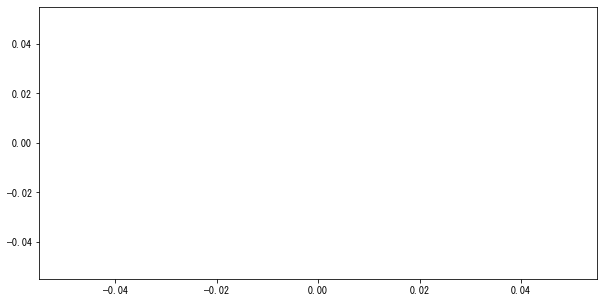

In [328]:
# 折れ線グラフで可視化
plt.figure(figsize=(10, 5))
plt.plot(X['発行かんばん数'], marker='o')
#X.head()

/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .r

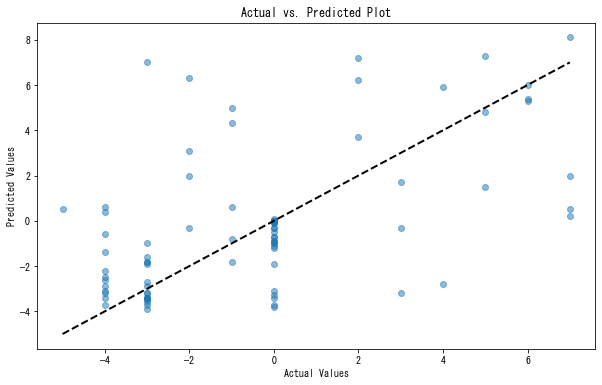

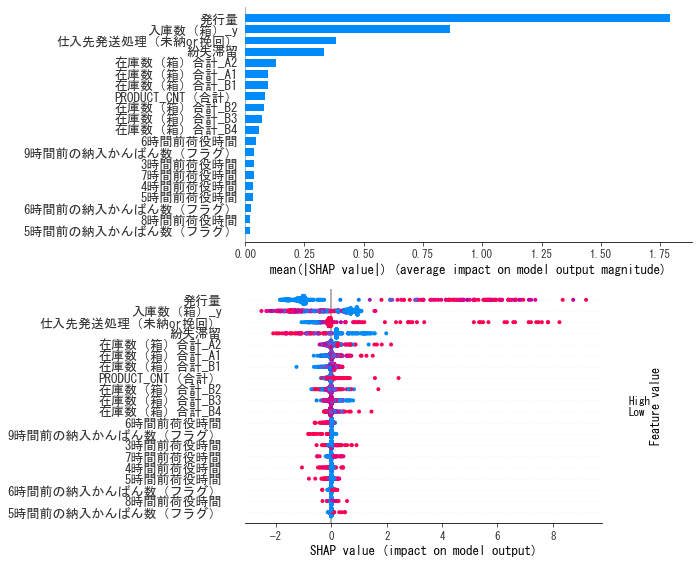

In [412]:
# フォント設定の変更（日本語対応のため）
mpl.rcParams['font.family'] = 'MS Gothic'

# データフレームXから100行目から300行目までのデータを選択
X_subset = X.iloc[0:5000]
# モデルを使ってX_subsetから予測値を計算
y_pred_subset = rf_model.predict(X_subset)
# y_test_subset を用意する必要がある
# この例では単に y_test の対応する部分を選択することを仮定
y_test_subset = y_test.loc[X_subset.index]

# 実測値と予測値をプロット
plt.figure(figsize=(10, 6))
# 散布図で実測値と予測値をプロット
# alpha=0.5で点の透明度を設定して、データポイントが重なる場合に可視性を高める
plt.scatter(y_test_subset, y_pred_subset, alpha=0.5)
# 対角線を描画（完璧な予測を示す線）
# y_test_subsetの最小値から最大値までの線を引く
plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], 'k--', lw=2)
# X軸のラベルを設定
plt.xlabel('Actual Values')
# Y軸のラベルを設定
plt.ylabel('Predicted Values')
# タイトルを設定
plt.title('Actual vs. Predicted Plot')

# 図を表示
plt.show()

# SHAP計算
explainer = shap.TreeExplainer(rf_model, feature_dependence='tree_path_dependent', model_output='margin')
shap_values_subset = explainer.shap_values(X_subset)

# グリッドレイアウトの設定
fig = plt.figure(figsize=(20, 20))  # サイズを実用的な大きさに調整
gs = GridSpec(2, 1, figure=fig)

# SHAPサマリープロット
ax1 = fig.add_subplot(gs[0, 0])
shap.summary_plot(shap_values_subset, X_subset, feature_names=X.columns, plot_type="bar", show=False)

# 平均絶対SHAP値のバープロット
ax2 = fig.add_subplot(gs[1, 0])
shap.summary_plot(shap_values_subset, X_subset, feature_names=X.columns, show=False)

        Unnamed: 0           品番           YYYYMMDDH  発行かんばん数  1時間前の発行かんばん数  \
299908      299908  9010512A018 2023-12-04 00:00:00      0.0           0.0   
300095      300095  9010512A018 2023-12-04 01:00:00      0.0           0.0   
300282      300282  9010512A018 2023-12-04 02:00:00      0.0           0.0   
300469      300469  9010512A018 2023-12-04 03:00:00      0.0           0.0   
300656      300656  9010512A018 2023-12-04 04:00:00      0.0           0.0   

        2時間前の発行かんばん数  3時間前の発行かんばん数  4時間前の発行かんばん数  5時間前の発行かんばん数  6時間前の発行かんばん数  \
299908           0.0           0.0           0.0           0.0           0.0   
300095           0.0           0.0           0.0           0.0           0.0   
300282           0.0           0.0           0.0           0.0           0.0   
300469           0.0           0.0           0.0           0.0           0.0   
300656           0.0           0.0           0.0           0.0           0.0   

        ...  PRODUCT_CNT  PRODUCT_CNT（合計）  PLAN_PR

/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

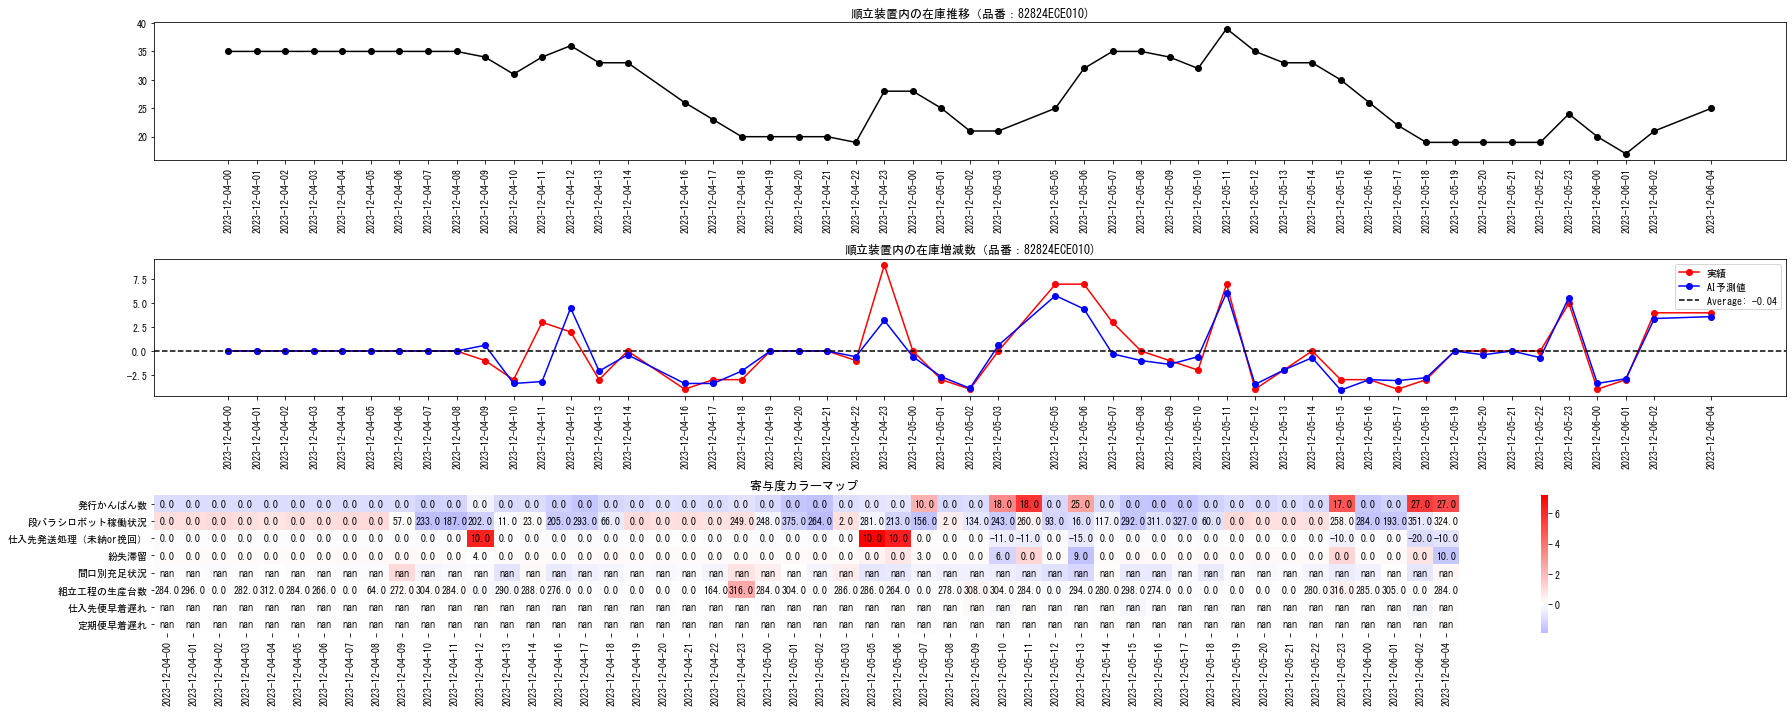

In [413]:
#data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu, encoding='shift_jis')

# 図の作成
plt.figure(figsize=(25, 10))

start = 0
end = 50

#df= data[data['品番'] == '019128GA010']
df=data.iloc[start:end]
print(df.head())

X_subset = X.iloc[start:end]
# モデルを使ってX_subsetから予測値を計算
y_pred_subset = rf_model.predict(X_subset)

df['YYYYMMDDH'] = pd.to_datetime(df['YYYYMMDDH'])
df.set_index('YYYYMMDDH', inplace=True)

df2 = df['在庫増減数']
print(df2.head())

df3 = df['在庫数（箱）']

# 折れ線グラフのサブプロット
plt.subplot(3, 1, 1) # (rows, columns, subplot number)
plt.plot(df3.index, df3, marker='o', linestyle='-', color='black')
plt.xticks(ticks=df3.index, labels=df3.index.strftime('%Y-%m-%d-%H'), rotation=90)  # 日付フォーマットは必要に応じて調整
plt.title('順立装置内の在庫推移（品番：82824ECE010)')

# 折れ線グラフのサブプロット
plt.subplot(3, 1, 2) # (rows, columns, subplot number)
plt.plot(df2.index, df2, marker='o', linestyle='-', color='red',label='実績')
plt.plot(df2.index, y_pred_subset, marker='o', linestyle='-', color='blue', label='AI予測値')
#plt.title('順立装置内の在庫推移（品番：82824ECE010、品名：CONNECTOR, WIRING HARNESS）')
# データの平均値を計算
mean_value = y.mean()
# 平均線の追加
plt.axhline(y=mean_value, color='black', linestyle='--', label=f'Average: {mean_value:.2f}')
plt.legend()  # 凡例の表示
plt.xticks(ticks=df2.index, labels=df2.index.strftime('%Y-%m-%d-%H'), rotation=90)  # 日付フォーマットは必要に応じて調整
plt.title('順立装置内の在庫増減数（品番：82824ECE010)')
plt.tight_layout()

# SHAP値からデータフレームを作成
shap_df = pd.DataFrame(shap_values_subset, columns=X.columns)

# 並び替えた特徴量に基づいてデータフレームを再構成
#荷役時間集約
shap_df['荷役時間'] = (shap_df["3時間前荷役時間"]+shap_df["4時間前荷役時間"]+shap_df["5時間前荷役時間"]+shap_df["6時間前荷役時間"]+shap_df["7時間前荷役時間"]+shap_df["8時間前荷役時間"])/6
shap_df = shap_df.drop(['3時間前荷役時間', '4時間前荷役時間','5時間前荷役時間', '6時間前荷役時間','7時間前荷役時間', '8時間前荷役時間'], axis=1)
#
#shap_df['発行時刻フラグ'] = shap_df["21時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["22時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["23時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["24時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["25時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["26時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["27時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["28時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["29時間前の発行かんばん数（フラグ）"] + \
                        #shap_df["30時間前の発行かんばん数（フラグ）"]
                        #shap_df["15時間前の発注かんばん数（フラグ）"] + \
                        #shap_df["16時間前の発注かんばん数（フラグ）"] + \
                        #shap_df["17時間前の発注かんばん数（フラグ）"] + \
                        #shap_df["18時間前の発注かんばん数（フラグ）"] + \
                        #shap_df["19時間前の発注かんばん数（フラグ）"] + \
                        #shap_df["20時間前の発注かんばん数（フラグ）"] + \
                        #shap_df["21時間前の発注かんばん数（フラグ）"] + \
                        #shap_df["22時間前の発注かんばん数（フラグ）"]
#shap_df['発行時刻フラグ'] = shap_df['発行時刻フラグ']#/8
#shap_df = shap_df.drop([
          #'21時間前の発行かんばん数（フラグ）', '22時間前の発行かんばん数（フラグ）', '23時間前の発行かんばん数（フラグ）', 
          #'24時間前の発行かんばん数（フラグ）', '25時間前の発行かんばん数（フラグ）', '26時間前の発行かんばん数（フラグ）', 
          #'27時間前の発行かんばん数（フラグ）', '28時間前の発行かんばん数（フラグ）','29時間前の発行かんばん数（フラグ）', '30時間前の発行かんばん数（フラグ）'], axis=1)
#
shap_df['納入時刻フラグ'] = shap_df["5時間前の納入かんばん数（フラグ）"] + \
                          shap_df["6時間前の納入かんばん数（フラグ）"] + \
                          shap_df["7時間前の納入かんばん数（フラグ）"] + \
                          shap_df["8時間前の納入かんばん数（フラグ）"] + \
                          shap_df["9時間前の納入かんばん数（フラグ）"]
shap_df['納入時刻フラグ'] = shap_df['納入時刻フラグ']#/5
shap_df = shap_df.drop(['5時間前の納入かんばん数（フラグ）', '6時間前の納入かんばん数（フラグ）', '7時間前の納入かんばん数（フラグ）',
          '8時間前の納入かんばん数（フラグ）', '9時間前の納入かんばん数（フラグ）'], axis=1)

shap_df['間口別充足状況'] = shap_df["在庫数（箱）合計_A1"] + \
                          shap_df["在庫数（箱）合計_A2"] + \
                          shap_df["在庫数（箱）合計_B1"] + \
                          shap_df["在庫数（箱）合計_B2"] + \
                          shap_df["在庫数（箱）合計_B3"] + \
                          shap_df["在庫数（箱）合計_B4"]
shap_df['間口別充足状況'] = shap_df['間口別充足状況']#/6
shap_df = shap_df.drop(['在庫数（箱）合計_A1', '在庫数（箱）合計_A2', '在庫数（箱）合計_B1',
          '在庫数（箱）合計_B2', '在庫数（箱）合計_B3', '在庫数（箱）合計_B4'], axis=1)
#shap_df = shap_df.drop(['入庫数（箱）合計'], axis=1)

#列名の変更
#shap_df = shap_df.rename(columns={'在庫数（箱）': '在庫数（箱）_1日の平均値'})

shap_df = shap_df.rename(columns={'発行量': '発行かんばん数'})
shap_df = shap_df.rename(columns={'入庫数（箱）_y': '段バラシロボット稼働状況'})
#shap_df = shap_df.rename(columns={'入庫数（箱）合計': '2h前から現在の入庫状況'})
shap_df = shap_df.rename(columns={'PRODUCT_CNT（合計）': '組立工程の生産台数'})
shap_df = shap_df.rename(columns={'間口別充足状況': '間口別充足状況'})
shap_df = shap_df.rename(columns={'納入時刻フラグ': '仕入先便早着遅れ'})
shap_df = shap_df.rename(columns={'荷役時間': '定期便早着遅れ'})
#shap_df = shap_df.rename(columns={'発行時刻フラグ': '発注タイミング早遅'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_A1': '2h前から現在の間口A1状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_A2': '2h前から現在の間口A2状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_B1': '2h前から現在の間口B1状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_B2': '2h前から現在の間口B2状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_B3': '2h前から現在の間口B3状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_B4': '2h前から現在の間口B4状況'})

X = X.rename(columns={'発行量': '発行かんばん数'})
X = X.rename(columns={'入庫数（箱）_y': '段バラシロボット稼働状況'})
#shap_df = shap_df.rename(columns={'入庫数（箱）合計': '2h前から現在の入庫状況'})
X = X.rename(columns={'PRODUCT_CNT（合計）': '組立工程の生産台数'})
X = X.rename(columns={'間口別充足状況': '間口別充足状況'})
X = X.rename(columns={'納入時刻フラグ': '仕入先便早着遅れ'})
X = X.rename(columns={'荷役時間': '定期便早着遅れ'})
#X = X.rename(columns={'発行時刻フラグ': '発注タイミング早遅'})

# データフレームの平均SHAP値に基づいて特徴量を並び替え
shap_df_mean = shap_df.abs().mean().sort_values(ascending=False)
sorted_columns = shap_df_mean.index

shap_df_sorted = shap_df[sorted_columns]

dfdf = shap_df_sorted.iloc[start:end].T
    
# カラーマップ（ヒートマップ）のサブプロット
plt.subplot(3, 1, 3)
sns.heatmap(dfdf, cmap='bwr', cbar=True, center=0)  # Transpose the DataFrame
plt.title('寄与度カラーマップ ')
plt.xticks(np.arange(0.5, len(df2.index)), df2.index.strftime('%Y-%m-%d-%H'), rotation=90)
# 各セルに値を追記
X = X.reindex(columns=shap_df_sorted.columns)
XX = X[start:end].T
for i in range(XX.shape[0]):
    for j in range(XX.shape[1]):
        formatted_value = "{:.1f}".format(XX.iloc[i, j])
        text = plt.text(j+0.5, i+0.5, formatted_value,
                       ha="center", va="center", color="black")
plt.tight_layout()

filename = 'モ'+ '.png'
plt.savefig(filename)

[<matplotlib.lines.Line2D at 0x14fb88dd0>]

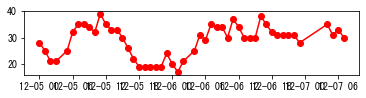

In [346]:
df3 = df['在庫数（箱）']

# 折れ線グラフのサブプロット
plt.subplot(3, 1, 1) # (rows, columns, subplot number)
plt.plot(df3.index, df3, marker='o', linestyle='-', color='red')

In [414]:
# dfdf.head(30)
#shap_df.head(30)
#print(len(data))
X.head(30)

,発行かんばん数,段バラシロボット稼働状況,仕入先発送処理（未納or挽回）,紛失滞留,間口別充足状況,組立工程の生産台数,仕入先便早着遅れ,定期便早着遅れ
299908,0.0,0.0,0.0,0.0,NaN,284.0,NaN,NaN
300095,0.0,0.0,0.0,0.0,NaN,296.0,NaN,NaN
300282,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
300469,0.0,0.0,0.0,0.0,NaN,282.0,NaN,NaN
300656,0.0,0.0,0.0,0.0,NaN,312.0,NaN,NaN
300843,0.0,0.0,0.0,0.0,NaN,284.0,NaN,NaN
301030,0.0,0.0,0.0,0.0,NaN,266.0,NaN,NaN
301217,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
301404,0.0,0.0,0.0,0.0,NaN,64.0,NaN,NaN
301591,0.0,57.0,0.0,0.0,NaN,272.0,NaN,NaN


In [76]:
#検証用
trydata = data

#データフレームの長さを確認したい
#print(len(trydata))

data['在庫増減数'].head()

# データフレームの各列のデータ型を確認
#trydata.dtypes
#データフレームのカラム表示
#trydata.columns.tolist()

#print(len(kanban_count_data))
#print(len(rackzaiko_data))
#print(len(merged_data_for_kanban_and_rackzaiko))
#merged_data_for_flag_and_sum.columns.tolist()#データフレームのカラム表示
#print(rackzaiko_data.head(500))
#print(kanban_count_data.head())
# 確認のため、データフレームの先頭数行を表示
#filtered_data = trydata[trydata['品番'] == 'G1163ECE010']
#filtered_data[['品番','1時間単位時刻' ,'発注かんばん数','1時間前の発注かんばん数','2時間前の発注かんばん数','3時間前の発注かんばん数','4時間前の発注かんばん数'
              #,'発注かんばん数（フラグ）','1時間前の発注かんばん数（フラグ）','2時間前の発注かんばん数（フラグ）','3時間前の発注かんばん数（フラグ）','4時間前の発注かんばん数（フラグ）']].head(50)
#filtered_data[['品番','YYYYMMDDH' ,'発注かんばん数','4時間前の発注かんばん数'
              #,'発注かんばん数（フラグ）','4時間前の発注かんばん数（フラグ）','発注量']].head(50)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 在庫増減数, dtype: float64

In [ ]:
#課題リスト
・荷役時間が数時間とかある。